In [712]:
import os
import folium
import numpy as np
import pandas as pd

pd.set_option('display.max_row', None)
pd.set_option('display.max_column', None)

import pymap3d as pm

from matplotlib import pyplot as plt

___

# Data Import

In [713]:
#Our results importing
#file_ins = "Our_results.txt" #This is directly in the required format and has time_utc already
#file_gt = "ground_truth.txt.nmea.body.ie"

In [714]:
#KF-GINS results
file_ins = 'training_dataset.csv'
file_gt = "y_train_dataset.csv" 

#### GT

In [715]:
results = pd.read_csv(file_ins, header=0)
results = results[results['Sample'] == 20]
results = results.drop(['Sample'], axis=1)
results.head(2)

,Week,GPSTime,Latitude,Longitude,H-Ell,Roll,Pitch,Heading
84757,0,357927.015837,30.451049,114.464856,27.973521,0.905960,1.356358,0.850911
84758,0,357927.020722,30.451049,114.464856,27.974086,0.911146,1.357904,0.852069


In [716]:
_ins = results.copy()

In [717]:
_gt = pd.read_csv(file_gt)
_gt = _gt[_gt['Sample'] == 20]
_gt = _gt.drop(columns=['Sample', 'North Velocity', 'East Velocity', 'Down Velocity'])
_gt.head(2)

,Week,GPSTime,Latitude,Longitude,H-Ell,Roll,Pitch,Heading
83214,0,357927.0123,30.451049,114.464856,27.97355,0.90152,1.35216,0.85153
83215,0,357927.0173,30.451049,114.464856,27.97406,0.90399,1.35446,0.85192


In [718]:
_gt = _gt[_gt.index > 0].copy()
_gt.head(2)

,Week,GPSTime,Latitude,Longitude,H-Ell,Roll,Pitch,Heading
83214,0,357927.0123,30.451049,114.464856,27.97355,0.90152,1.35216,0.85153
83215,0,357927.0173,30.451049,114.464856,27.97406,0.90399,1.35446,0.85192


In [719]:
_gt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2814 entries, 83214 to 86027
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Week       2814 non-null   int64  
 1   GPSTime    2814 non-null   float64
 2   Latitude   2814 non-null   float64
 3   Longitude  2814 non-null   float64
 4   H-Ell      2814 non-null   float64
 5   Roll       2814 non-null   float64
 6   Pitch      2814 non-null   float64
 7   Heading    2814 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 197.9 KB


___

# Clean Up

In [720]:
cast_dict = {}
for col in _gt.columns:
    cast_dict[col] = float
cast_dict['Week'] = int

for _df in [_gt, _ins]:
    _df = _df.astype(cast_dict)

In [721]:
_ins.head(2)

,Week,GPSTime,Latitude,Longitude,H-Ell,Roll,Pitch,Heading
84757,0,357927.015837,30.451049,114.464856,27.973521,0.905960,1.356358,0.850911
84758,0,357927.020722,30.451049,114.464856,27.974086,0.911146,1.357904,0.852069


In [722]:
col_map = {
        'Week'              : "gps_week",
        'GPSTime'           : "gps_sec",
        'Latitude'          : 'lat',
        'Longitude'         : 'lon',
        'H-Ell'             : 'alt',
        'Heading'           : 'heading',
        'Pitch'             : 'pitch',
        'Roll'              : 'roll',
}

In [723]:
gt = pd.DataFrame()
ins = pd.DataFrame()

_map_old_df_ = {"_ins": _ins, 
                "_gt": _gt }

_map_new_df_ = {"_ins" : ins, 
                "_gt": gt}

In [724]:
SECONDS_IN_GPS_WEEK = 604800.0
def gpst2utc(gps_week, gps_seconds):
    '''
    To time associate IMU data with GNSS data, GNSS data's time stamps which are in 
    GPS time must be converted to UTC time, this funciton does that. 

    Code from the open-soruce data set repo https://github.com/IPNL-POLYU/UrbanNavDataset/blob/master/docs/GETTING_STARTED.md
    '''
    utctime = (gps_week * SECONDS_IN_GPS_WEEK + gps_seconds-18) + 315964800
    return utctime

In [725]:
for df_key in _map_old_df_.keys():
    for col_key, val in col_map.items():
        _map_new_df_[df_key][val] = _map_old_df_[df_key][col_key] 

for _df in _map_new_df_.values():
    _df['time_utc'] = _df.apply(lambda x: gpst2utc(x['gps_week'], x['gps_sec']), axis=1)


In [726]:
gt.head(2)

,gps_week,gps_sec,lat,lon,alt,heading,pitch,roll,time_utc
83214,0,357927.0123,30.451049,114.464856,27.97355,0.85153,1.35216,0.90152,3.163227e+08
83215,0,357927.0173,30.451049,114.464856,27.97406,0.85192,1.35446,0.90399,3.163227e+08


In [727]:
ins.head(2)

,gps_week,gps_sec,lat,lon,alt,heading,pitch,roll,time_utc
84757,0,357927.015837,30.451049,114.464856,27.973521,0.850911,1.356358,0.905960,3.163227e+08
84758,0,357927.020722,30.451049,114.464856,27.974086,0.852069,1.357904,0.911146,3.163227e+08


___

In [728]:
t_min = max(gt['time_utc'].min(),
            ins['time_utc'].min(),)

t_max = gt['time_utc'].max()

print(t_min, t_max)


316322709.0158369 316322723.0073


In [729]:
t_mid = (t_min + t_max) / 2
row_mid_gt = gt.loc[(gt.time_utc - t_mid).abs().idxmin()]
row_mid_gt

gps_week    0.000000e+00
gps_sec     3.579340e+05
lat         3.045172e+01
lon         1.144648e+02
alt         2.894528e+01
heading     2.494040e+00
pitch       1.363960e+00
roll        9.275400e-01
time_utc    3.163227e+08
Name: 84621, dtype: float64

In [730]:
lat_mid, lon_mid, h_mid = row_mid_gt['lat'], row_mid_gt['lon'], row_mid_gt['alt']

In [731]:
import math
t_a = math.floor(t_min)
t_b = math.floor(t_max)

In [732]:
plot_start = t_a - 10
plot_stop = t_b

In [733]:
# #This was added for the ENU conversion to work as my results file is slightly different
# _map_new_df_ = {"_ins": ins, 
#                 "_gt": gt}

In [734]:
for _df in _map_new_df_.values():
    _df['E'], _df['N'], _df['U'] = zip(*_df.apply(lambda x: pm.geodetic2enu(x['lat'], x['lon'], x['alt'], 
                                                                            ins['lat'].iloc[0] , ins['lon'].iloc[0] , ins['alt'].iloc[0] ), 
                                                                            axis=1))

In [735]:
ins.head(10)

,gps_week,gps_sec,lat,lon,alt,heading,pitch,roll,time_utc,E,N,U
84757,0,357927.015837,30.451049,114.464856,27.973521,0.850911,1.356358,0.905960,3.163227e+08,-0.000000,0.000000,0.000000
84758,0,357927.020722,30.451049,114.464856,27.974086,0.852069,1.357904,0.911146,3.163227e+08,-0.001537,0.048335,0.000565
84759,0,357927.025615,30.451050,114.464856,27.974648,0.853567,1.359322,0.915096,3.163227e+08,-0.003170,0.096560,0.001127
84760,0,357927.030491,30.451050,114.464856,27.975219,0.855241,1.361030,0.918928,3.163227e+08,-0.004802,0.144784,0.001697
84761,0,357927.035386,30.451051,114.464856,27.975805,0.856675,1.362962,0.922730,3.163227e+08,-0.006531,0.193230,0.002283
84762,0,357927.040273,30.451051,114.464856,27.976401,0.858268,1.364159,0.924167,3.163227e+08,-0.008164,0.241454,0.002879
84763,0,357927.045157,30.451052,114.464856,27.977004,0.859950,1.363302,0.924091,3.163227e+08,-0.009797,0.289790,0.003483
84764,0,357927.050028,30.451052,114.464856,27.977611,0.862140,1.362144,0.923051,3.163227e+08,-0.011526,0.338014,0.004090
84765,0,357927.054913,30.451053,114.464856,27.978216,0.863963,1.360919,0.922051,3.163227e+08,-0.013255,0.386349,0.004695
84766,0,357927.059807,30.451053,114.464856,27.978809,0.865544,1.361407,0.921363,3.163227e+08,-0.014887,0.434795,0.005288


In [736]:
gt.head(10)

,gps_week,gps_sec,lat,lon,alt,heading,pitch,roll,time_utc,E,N,U
83214,0,357927.0123,30.451049,114.464856,27.97355,0.85153,1.35216,0.90152,3.163227e+08,0.000010,0.001197,0.000029
83215,0,357927.0173,30.451049,114.464856,27.97406,0.85192,1.35446,0.90399,3.163227e+08,-0.001652,0.050564,0.000539
83216,0,357927.0223,30.451050,114.464856,27.97467,0.85339,1.35833,0.90649,3.163227e+08,-0.003304,0.099963,0.001149
83217,0,357927.0273,30.451050,114.464856,27.97516,0.85414,1.35979,0.90451,3.163227e+08,-0.004937,0.149385,0.001639
83218,0,357927.0323,30.451051,114.464856,27.97576,0.85560,1.36133,0.90494,3.163227e+08,-0.006598,0.198795,0.002239
83219,0,357927.0373,30.451051,114.464856,27.97626,0.85665,1.36514,0.90612,3.163227e+08,-0.008260,0.248228,0.002739
83220,0,357927.0423,30.451052,114.464856,27.97686,0.85805,1.36697,0.90737,3.163227e+08,-0.009941,0.297694,0.003339
83221,0,357927.0473,30.451052,114.464856,27.97746,0.85946,1.36427,0.90611,3.163227e+08,-0.011631,0.347171,0.003939
83222,0,357927.0523,30.451053,114.464856,27.97806,0.86131,1.36236,0.90573,3.163227e+08,-0.013341,0.396648,0.004539
83223,0,357927.0573,30.451053,114.464856,27.97866,0.86288,1.36088,0.90617,3.163227e+08,-0.015051,0.446136,0.005139


In [737]:
gt['time_utc'].iloc[-1]

316322723.0073

In [738]:
ins['time_utc'].iloc[-1]

316322723.00511795

In [739]:
gt = gt[(gt['time_utc'] >= t_a) & (gt['time_utc'] <= t_b)]

In [740]:
ins_plot = ins[(ins['time_utc'] >= (t_a)) & (ins['time_utc'] <= (t_b))]

In [741]:
ins_plot.head(2)

,gps_week,gps_sec,lat,lon,alt,heading,pitch,roll,time_utc,E,N,U
84757,0,357927.015837,30.451049,114.464856,27.973521,0.850911,1.356358,0.905960,3.163227e+08,-0.000000,0.000000,0.000000
84758,0,357927.020722,30.451049,114.464856,27.974086,0.852069,1.357904,0.911146,3.163227e+08,-0.001537,0.048335,0.000565


In [742]:
gt_plot = gt[(gt['time_utc'] > (t_a)) & (gt['time_utc'] < (t_b))]

In [743]:
gt_plot.head(2)

,gps_week,gps_sec,lat,lon,alt,heading,pitch,roll,time_utc,E,N,U
83214,0,357927.0123,30.451049,114.464856,27.97355,0.85153,1.35216,0.90152,3.163227e+08,0.000010,0.001197,0.000029
83215,0,357927.0173,30.451049,114.464856,27.97406,0.85192,1.35446,0.90399,3.163227e+08,-0.001652,0.050564,0.000539


In [744]:
(ins['time_utc'] - ins['time_utc'].shift(100)).mean()

0.4884525804580013

Text(0, 0.5, 'North Position (m)')

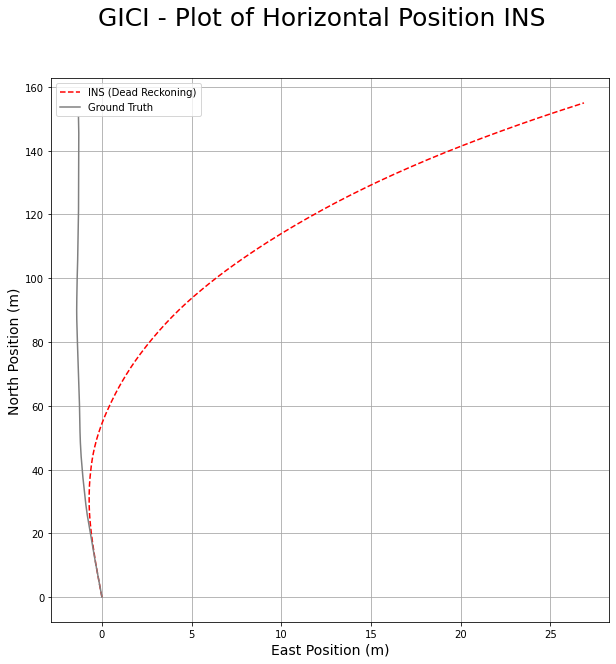

In [745]:
fig, axs = plt.subplots(figsize=(10,10))

axs.plot(ins_plot['E'], ins_plot['N'], '--', color='r', label='INS (Dead Reckoning)')
axs.plot(gt_plot['E'], gt_plot['N'], color='grey', label='Ground Truth')

fig.suptitle("GICI - Plot of Horizontal Position INS", size=25)

axs.grid(True, which='both',ls='-',color='0.65')
axs.legend()
axs.set_xlabel("East Position (m)", size=14)
axs.set_ylabel("North Position (m)", size=14)

In [746]:
_ins_gt = pd.merge_asof(
                    left=ins,
                    right=gt,
                    left_on="time_utc",
                    right_on="time_utc",
                    suffixes=['', '_gt'],
                    direction="nearest")


In [747]:
_ins_gt['sec_diff'] = abs(_ins_gt['gps_sec'] - _ins_gt['gps_sec_gt'])

In [748]:
ins_gt = _ins_gt.sort_values(['time_utc','sec_diff'], ascending=True).drop_duplicates(subset=['gps_sec_gt'], keep='first')

In [749]:
ins_gt = ins_gt[(ins_gt['time_utc'] >= t_a) & (ins_gt['time_utc'] <= t_b)]

In [750]:
for _df in [ins_gt]:
        _df['dE'], _df['dN'], _df['dU'] = zip(*_df.apply(lambda x: pm.geodetic2enu(x['lat'], x['lon'], x['alt'], 
                x['lat_gt'], x['lon_gt'], x['alt_gt'],), 
        axis=1))

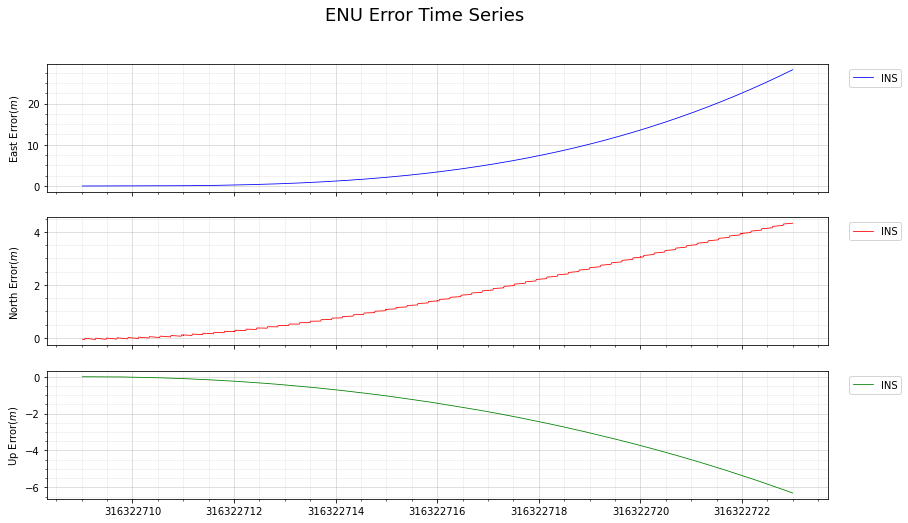

In [751]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, axs = plt.subplots(nrows=3,ncols=1, figsize=(14,8), sharex=True)
axs[0].plot(ins_gt['time_utc'], ins_gt['dE'], color='b', label='INS', linewidth=0.8)
axs[1].plot(ins_gt['time_utc'], ins_gt['dN'], color='r', label='INS', linewidth=0.8)
axs[2].plot(ins_gt['time_utc'], ins_gt['dU'], color='g', label='INS', linewidth=0.8)

axs[0].set_ylabel(r'East Error$\left(m\right)$', size=10)
axs[1].set_ylabel(r'North Error$\left(m\right)$', size=10)
axs[2].set_ylabel(r'Up Error$\left(m\right)$', size=10)


fig.suptitle("ENU Error Time Series", size=18)
#fig.supxlabel(r'$t_{rel}$ $(s)$', size=14)
fig.align_ylabels()

for i, ax in enumerate(axs):

    top_ = max(ax.get_yticks())
    bot_ = min(ax.get_yticks())
    
    # if i == 0:
    #     ax.fill_between(_times_rel_blkout_imu,top_*_blkout_imu_ones,color='red', alpha=0.2, label="No GNSS")
    # else:
    #     ax.fill_between(_times_rel_blkout_imu,top_*_blkout_imu_ones,color='red', alpha=0.2)
        
    # ax.fill_between(_times_rel_blkout_imu,bot_*_blkout_imu_ones,color='red', alpha=0.2)

    ax.legend(bbox_to_anchor=[1.1,1])
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.locator_params(nbins=4,axis='y')
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    # ax.locator_params(nbins=20,axis='x')
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.ticklabel_format(useOffset=False,style='plain')



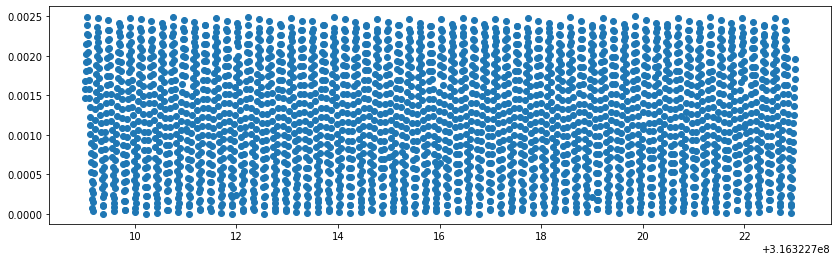

In [752]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,4))
ax.scatter(ins_gt['time_utc'], ins_gt['sec_diff'])


In [753]:
def get_track_len(df: pd.DataFrame, 
                col_x: str,
                col_y: str,
                col_z: str):
    __ret = 0
    for _col in [col_x, col_y, col_z]:
        __ret += np.square(df[_col] - df[_col].shift(-1))

    return np.sum(np.sqrt(__ret))


def get_3d_rmse(df: pd.DataFrame,
                col_dx: str, 
                col_dy: str,
                col_dz: str):
    __ret = 0
    for _col in [col_dx, col_dy, col_dz]:
        __ret += np.square(df[_col])

    return np.sqrt(np.mean(__ret))

def get_2d_rmse(df: pd.DataFrame,
                col_dx: str, 
                col_dy: str,):
    __ret = 0
    for _col in [col_dx, col_dy]:
        __ret += np.square(df[_col])

    return np.sqrt(np.mean(__ret))

In [754]:
out_dict_ = {}
out_dict_['3D_RMSE'] = {}
out_dict_['3D_RMSE_OUT'] = {}
out_dict_['2D_RMSE'] = {}
out_dict_['2D_RMSE_OUT'] = {}
out_dict_['Track_Length'] = {}

out_dict_['3D_RMSE']['INS_DR'] = get_3d_rmse(ins_gt, 'dE', 'dN', 'dU')



out_dict_['2D_RMSE']['INS_DR'] = get_2d_rmse(ins_gt, 'dE', 'dN')

out_dict_['Track_Length']['GT'] = get_track_len(
                                        gt[(gt['time_utc'] >= t_a) & (gt['time_utc'] <= t_b)],
                                'E', 'N', 'U')
out_dict_['3D_RMSE_OUT']['INS_DR'] = get_3d_rmse(
                ins_gt[(ins_gt['time_utc'] >= t_a) & (ins_gt['time_utc'] <= t_b)], 
                                'dE', 'dN', 'dU')

out_dict_['2D_RMSE_OUT']['INS_DR'] = get_2d_rmse(
                ins_gt[(ins_gt['time_utc'] >= t_a) & (ins_gt['time_utc'] <= t_b)], 
                                'dE', 'dN')


In [755]:
out_df_ = pd.DataFrame(out_dict_)
out_df_['2D_Percent'] = out_df_['2D_RMSE_OUT']/ out_df_['Track_Length']['GT'] * 100 
out_df_['3D_Percent'] = out_df_['3D_RMSE_OUT']/ out_df_['Track_Length']['GT'] * 100

for col in out_df_.columns:
    out_df_[col] = np.round(out_df_[col], 4)

out_df_

,3D_RMSE,3D_RMSE_OUT,2D_RMSE,2D_RMSE_OUT,Track_Length,2D_Percent,3D_Percent
INS_DR,11.171,11.171,10.8314,10.8314,NaN,7.1886,7.414
GT,NaN,NaN,NaN,NaN,150.6751,NaN,NaN
